# GLLVM for longitudinal data: a pytorch implementation

We consider the following model

TODO:
* learn the nuisance parameters! To learn phi, make the encoder learn the zhats **before** AR(1) is applied, and take the gradient of the decoder. that is, make the decoder have phi as a parameter, and same for var_mu!
* allow for gaussian and binary data
* Compute the gradient that define the model
* allow for missing values and impute them
* define mine own loss.




 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable accounts for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a non-stationary autoregressive model of first order

\begin{equation*}
z_{it}=\phi z_{i,t-1} + \delta_{it}
\end{equation*}%
where  $z_{i1}\sim N(0,\sigma^2_{1})$ and $\delta_{it}\sim N(0,1)$.  Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.



## Measurement invariance

The  latent variable $z_{it}$ has to be the same (same meaning) across occasions.
Thus the measurement invariance assumption has to be tested on the data, that is 
all the measurement parameters  are invariant across occasions, that is $$\beta_{0jt}=\beta_{0j} \ \textrm{and } \ \lambda_{jt}=
\lambda_{j},$$ for all $t$, $t=1, \ldots, T$ and for all $j$, $j=1,\ldots, p$.
Under this assumption, the model is more parsimonious  and avoids some possible identification problem that might arise with
increasing the number of time points.

To ensure identification of the model, one necessary condition is that the latent variable has a scale and an origin. %When measurement
%invariance of loadings and intercepts is imposed,
Scale for  $z_{it}$  can be provided either by fixing one loading at a nonzero value or by
fixing the factor variance at a nonzero value. In presence of longitudinal data, the same loading is fixed equal to one at each occasion.


## Pytorch Modeling

We model each observation as a tuple of dimension `(T, p)`, common across individuals. Individuals constitute independent observations, which yields the tensor structure `(n, T, q)`. The time dimension `T` appears in the first dimension since it allows for seamless tensor products of the type `(n, T, q) (q, p)`.

The design of the `GLLVM` architecture is as follows: we need

* a GLLVM module, which is the model, and contains methods to sample, and has an `AR1` module as well as a `CondMean` module: the first creates the auto-regressive sequence, the second 
* the `AR1` module, given a sample of independent noise `delta` and parameter `phi`, returns the auto-regressive process according to the above formula
* the `CondMean` module which computes the conditional mean which is used in the loss function. This depends on the weights `wx`, `wz`, the biases `b`, and t
* a sample method to generate the random variables jointly from the GLLVM. This includes the noise `delta`, the individual-specific random intercepts `u`, and the responses of various types. Additionally, for responses (features) types that require a scale parameter, this includes the `scale` parameter.  
* an `Encoder` module that maps the features to the `unmodified` latent variables `u` and `d` (before any parameter affects them), which is learned on the samples, who has its own architecture and parameters which we do not directly care about.
* our very own M-estimator loss function
* interestingly, the number of parameters do not depend on time nor on number of observations.

The data is organized in a 3-dimensional tensor `(batch, seq_length, features)`. 


In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

n = 100
p = 15
T = 20
k = 8
q = 1

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)




class Decoder(nn.Module):
    """Computes the conditional mean of the gllvm."""
    def __init__(self, num_latents, num_features, num_covariates):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.randn((num_latents, num_features)))
        self.wx = nn.Parameter(torch.randn((num_covariates, num_features)))
        self.bias = nn.Parameter(torch.zeros((1, num_features)))

    # decoding
    def forward(self, x, z, u, features_id, features_linkinv):
        """Combine the z, the u, and the x into the conditional means. The z and the u are already sampled, no need to transform them further."""
        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see section "details of tensorproducts"
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()

        # Compute the linear predictor
        linpar = self.bias + xwx + zwz + u 

        # Create a placeholder for the conditional means
        condmean  = torch.zeros_like(linpar)
        # The conditional mean is obtained by applying the inverse link to the linear prepdictor.
        # For computational efficiency reasons, we apply the inverse link on all response of the same types in one go.
        # It is safe here to modify condmean in-place because the replaced elements have not been used in the computational graph before.
        for feature_type, id in features_id.items():
            condmean[:,:,id] = features_linkinv[feature_type](linpar[:,:,id])

        return condmean
    

class AR1(nn.Module):
    """Implementation of an AR1 model."""
    def __init__(self):
        super().__init__()
        # Initialize the phi parameter (the only parameter of the AR1 process)
        self.phi = nn.Parameter(torch.ones(1)*.5)
    
    def forward(self, d):
        # 'd' is the input tensor containing the noise terms of dimensions (num_observations, seq_length, num_features)

        # Initialize output list with the first noise term
        z_list = [d[:,0,:]]

        # Generate the AR(1) sequence by iteratively adding the effect of
        # previous term (scaled by phi) and the current noise term
        for i in range(1, d.shape[1]):
            z_list.append(z_list[i-1] * self.phi + d[:,i,:])

        # Concatenate the list to create our new tensor along the time dimensions 1
        z = torch.stack(z_list, dim=1)
        
        return z
    
    def compute_d(self, z):
        """
        Given z, return d. This is the inverse function of forward.
        """
        d_list = [z[:,0,:]]

        for i in range(1, z.shape[1]):
            state = z[:,i-1,] * self.phi
            di = z[:,i,:] - state
            d_list.append(di)
        
        d = torch.stack(d_list, dim=1)

        return d



# The encoder tries to learn the latent variables given the observations. Since the encoder learns on simulated data, it knows the true value of the latent. Given the latent, there is no time dependence 
# in this model so no need to consider recursive neural network; a simple feed-forwward neural network can do the trick. What's more, no need to consider the time dimension, although we will here. the network has the same parameters anyway.

# The encoder needs to encode the random effects (u) and the latent variables (z)

class Encoder(nn.Module):
    """
    Encodes the features into the latent space.
    """

    def __init__(self, num_features, num_covariates, hidden_size, num_latents):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features + num_covariates, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        self.encoder_z = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_latents)
        )

        self.encoder_u = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_features)
        )

    
    def forward(self, x, y):
        """
        Forward on the whole dataset;  Process the whole sequence at once, leveraging shared parameters.
        """

        # concatnenate x and y in the features dimension
        xy = torch.cat([x, y], dim=2)
        z_hat = []
        u_hat = []

        for i in range(xy.shape[1]):
            # select the ith dimension slice
            slice_i = xy[:, i, :]
            # apply the forward pass to the slice
            intermediate_output = self.encoder(slice_i)
            output_z = self.encoder_z(intermediate_output)
            output_u = self.encoder_u(intermediate_output)
            z_hat.append(output_z)
            u_hat.append(output_u)

        # concatenate the output and create a new time dimension
        z_hat = torch.stack(z_hat, dim=1)
        u_hat = torch.stack(u_hat, dim=1)
        u_hat = torch.mean(u_hat, dim=1, keepdim=True)

        return z_hat, u_hat

class GLLVM(nn.Module):
    """
    GLLVM model
    
    Args:
        var_types: a dictionary of key:value pairs with keys one of "gaussian", "poisson", "ordinal", "binary, and values being a list of indices.
    """
    def __init__(self, num_latents, num_features, num_covariates, features_id, features_linkinv_sample, features_linkinv_forward, features_transform):
        super().__init__()
        # Initialize feature types
        self.features_id = features_id
        self.features_linkinv_sample = features_linkinv_sample
        self.features_linkinv_forward = features_linkinv_forward
        self.features_transform = features_transform

        # Initialize the model dimensions. Note that the number of observations and the sequence length are not model parameters but characteristics of the data.
        self.num_features = num_features
        self.num_latents = num_latents
        self.num_covariates = num_covariates

        # Initialize the modules 
        self.ar1 = AR1()
        self.decoder = Decoder(self.num_latents, self.num_features, self.num_covariates)
        self.encoder = Encoder(self.num_features, self.num_covariates, 50, self.num_latents)

        # Initialize Parameters
        self.bias = nn.Parameter(torch.zeros((1,1,self.num_features))) # one bias term per response, shared accross time and observations
        self.var_u = nn.Parameter(torch.ones((1,1,self.num_features)))
        self.var_y = nn.Parameter(torch.ones((1,1,self.num_covariates))) # this appears in the loss function, but we know all of them to be 1 by design   
    
    def autoencode(self, x, y):
        z, u = self.encoder(x, y)
        d = self.ar1.compute_d(z)
        u = u/torch.sqrt(self.var_u)
        reconstructed = self(x, d, u)
        return reconstructed


    def impute(self, x, y, mask=None):
        """Impute the data. If mask is set to none, initialize imputation"""
        self.eval()
        # If mask is none, initialize imputation by the mean of the features (in dim 2)
        if mask is None:
            mask = ( y == np.nan)
            y[mask] = torch.nanmean(y, dim=(0,1), keepdim=True).repeat(y.shape[0], y.shape[1], 1)[mask]
        else:
            y[mask] = self.autoencode(x, y)[mask]
        return y, mask


    def forward(self, x, d, u):
        z = self.ar1(d)
        u = u * self.var_u
        yhat = self.decoder(x, z, u, self.features_id, self.features_linkinv_forward)
        return yhat

    def sample(self, n, seq_length, x=None, u=None, d=None):
        """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, z, u, d, y)."""

        with torch.no_grad():
            if x is None:
                Warning("xb was set to None for sampling. This is usually unwanted unless k=0. Here k is set to.")
                x = torch.randn((n, seq_length, self.num_covariates))

            if d is None:
                d = torch.randn((n, seq_length, self.num_latents))
        
            if u is None:
                u = torch.randn((n, 1, self.num_features)) * torch.sqrt(self.var_u)
        
            z = self.ar1(d)

            condmean = self.decoder(x, z, u, self.features_id, self.features_linkinv_sample)

            y = torch.zeros_like(condmean)

            # Sample and transform where necessary
            for feature_type, id in self.features_id.items():
                if feature_type == "binary":
                    y_sample = torch.bernoulli(condmean[:,:,id])
                elif feature_type == "ordinal":
                    # TODO: re-write this part and comment better
                    y_ordinal = condmean[:,:,id]
                    # draw one uniform for the whole vector
                    random = torch.rand((*y_ordinal.shape[0:2], 1)) 
                    # compare with the cumulative probabilities
                    ordinal = torch.sum(random < y_ordinal, axis=2)
                    ordinal = torch.nn.functional.one_hot(ordinal).squeeze().float()
                    ordinal = ordinal[:,:,1:] # discard the first column of the one_hot encoding, as it is superfluous (as a 0)
                    y_sample = ordinal
                elif feature_type == "counts":
                    y_sample = torch.poisson(condmean[:,:,id]) # here we transform the mean using the inverse link - this is due to the transformation of the poisson variable intot a "gaussin". For sampling, we actually want the gaussian.

                # Transform if any transformation was specified
                if feature_type in self.features_transform:
                    y_sample = self.features_transform[feature_type](y_sample)
                
                y[:,:,id] = y_sample

        return {"x":x, "y":y, "z":z, "u":u, "d":d}

Training functions

In [2]:
def train_encoder(x, y, z, u, model, optimizer, criterion, num_epochs=100, validation_data=None, verbose=True, random=False, **kwargs):
    """
    Train a PyTorch model and return the model and the history of losses.

    :param x: The input data for model
    :param y: The labels for input data
    :param z: additional input data
    :param u: additional input data
    :param model: PyTorch model to train
    :param optimizer: Optimizer to use in training
    :param criterion: Loss function to use in training
    :param num_epochs: Number of training epochs. Default is 100.
    :param validation_data: Tuple of validation data (x_val, y_val, z_val, u_val). Default is None.
    :return: Tuple of trained model and history of losses.
    """
    # Switch model to training mode
    model.train()
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        if random:
            x, y, z, u, _ = model.sample(y.shape[0], y.shape[1], x = x).values()
        optimizer.zero_grad()

        # Forward pass
        outputs_z, outputs_u = model.encoder(x, y)

        loss_z = criterion(outputs_z, z)
        loss_u = criterion(outputs_u, u)

        # Compute loss

        loss = loss_z + loss_u

        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if validation_data is not None:
            model.eval() # switch model to evaluation mode
            with torch.no_grad():
                x_val, y_val, z_val, u_val, _ = validation_data.values()
                val_z, val_u = model.encoder(x_val, y_val)
                val_loss_z =  criterion(val_z, z_val)
                val_loss_u = criterion(val_u, u_val)
                val_loss = val_loss_z + val_loss_u
                val_losses.append(val_loss.item())
            model.train() # switch model back to training mode

        if verbose and (epoch % 10) == 0:
            print(f'Epoch: {epoch}, Training Loss: {loss.item()}, Val loss = {None if validation_data is None else val_loss}')

    return model, train_losses, val_losses

In [3]:
# try generating data
features_id = {
    'binary': [0,1,2,3,4,5,6,7],
    'ordinal': [9, 10],
    'counts': [8, 11, 12]
}

# We define two inverse link functions; one for sampling (the one assumed in the model), and another for computations (the one used to compute gradients)
features_linkinv_sample = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: torch.exp(x) 
}

# We define two inverse link functions; one for sampling (the one assumed in the model), and another for computations (the one used to compute gradients)
features_linkinv_forward = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: x
}

features_transform = {
    #'binary': lambda x: 2* (x - .5),
    #'ordinal': lambda x: (x -5)/5,
    'counts': lambda x: torch.log(x + 1)
}

num_latents = 1
num_features = 13
num_covariates = 3


model_true = GLLVM(num_latents, num_features, num_covariates, features_id, features_linkinv_sample, features_linkinv_forward, features_transform)

model = GLLVM(num_latents, num_features, num_covariates, features_id, features_linkinv_sample, features_linkinv_forward, features_transform)
from copy import deepcopy
model = deepcopy(model_true)

# Draw data from the true model
data_true = model_true.sample(200, 9)
val_data = model_true.sample(200, 9, x=data_true['x'])


## Test the encoder

How good is the encoder at encoding? train on one dataset, evaluate on another.


In [4]:
optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [5]:
train_encoder(**data_true, model=model, optimizer=optimizer, criterion=criterion, validation_data=val_data, num_epochs=1000, random=True)

Epoch: 0, Training Loss: 2.3555562496185303, Val loss = 2.289383888244629
Epoch: 10, Training Loss: 2.279022216796875, Val loss = 2.2188591957092285
Epoch: 20, Training Loss: 2.1575980186462402, Val loss = 2.053225040435791
Epoch: 30, Training Loss: 1.793822169303894, Val loss = 1.6832876205444336
Epoch: 40, Training Loss: 1.3890771865844727, Val loss = 1.3994807004928589
Epoch: 50, Training Loss: 1.2958533763885498, Val loss = 1.303268551826477
Epoch: 60, Training Loss: 1.2596155405044556, Val loss = 1.2560166120529175
Epoch: 70, Training Loss: 1.2722269296646118, Val loss = 1.2247809171676636
Epoch: 80, Training Loss: 1.2079123258590698, Val loss = 1.1966116428375244
Epoch: 90, Training Loss: 1.1565247774124146, Val loss = 1.1767849922180176
Epoch: 100, Training Loss: 1.1880595684051514, Val loss = 1.1522541046142578
Epoch: 110, Training Loss: 1.2044222354888916, Val loss = 1.1352417469024658
Epoch: 120, Training Loss: 1.1622223854064941, Val loss = 1.1244322061538696
Epoch: 130, Tra

(GLLVM(
   (ar1): AR1()
   (decoder): Decoder()
   (encoder): Encoder(
     (encoder): Sequential(
       (0): Linear(in_features=16, out_features=50, bias=True)
       (1): ReLU()
       (2): Linear(in_features=50, out_features=50, bias=True)
       (3): ReLU()
     )
     (encoder_z): Sequential(
       (0): Linear(in_features=50, out_features=50, bias=True)
       (1): ReLU()
       (2): Linear(in_features=50, out_features=50, bias=True)
       (3): ReLU()
       (4): Linear(in_features=50, out_features=1, bias=True)
     )
     (encoder_u): Sequential(
       (0): Linear(in_features=50, out_features=50, bias=True)
       (1): ReLU()
       (2): Linear(in_features=50, out_features=50, bias=True)
       (3): ReLU()
       (4): Linear(in_features=50, out_features=13, bias=True)
     )
   )
 ),
 [2.3555562496185303,
  2.364841938018799,
  2.26399564743042,
  2.3544061183929443,
  2.247199058532715,
  2.31443190574646,
  2.2559638023376465,
  2.2599849700927734,
  2.2586607933044434,
  

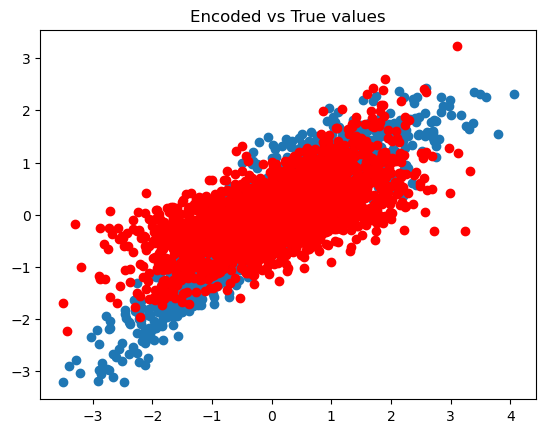

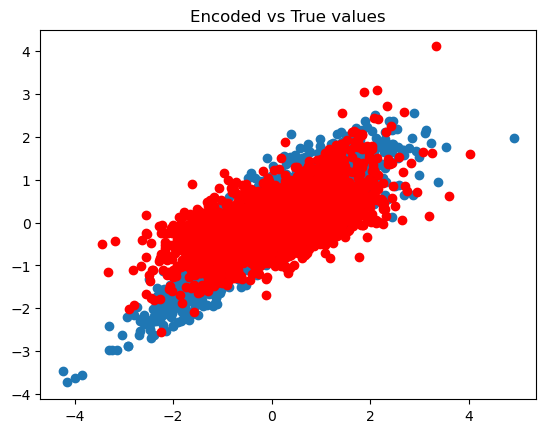

In [6]:
# Plot this
def plot_encoded(data, model):
    with torch.no_grad():
        zhat, uhat = model.encoder(data['x'], data['y'])
        plt.scatter(data['z'].numpy(), zhat.detach().numpy())
        plt.scatter(data['u'].numpy(), uhat.detach().numpy(), color="red")
        plt.title("Encoded vs True values")
    plt.show()

plot_encoded(val_data, model)
plot_encoded(data_true, model)

## Train model

We train the parameters of the decoder and encoder separately: the encoder is trained on simulated data, and the decoder is trained on the sample, and centered in expectation by the simulated data. The training loop goes as follows:

* Initialize encoder and decoder losses and optimizers
* Create the mask of missing values, and initialize imputation

* sample (marginally) from the model (still given the covariates `x`) (no grad)
* update the encoder (grad)
* encode both the sample and the decoder (no grad)
* update the decoder (grad), taking into account the missing value mask
* update the imputations


In [7]:
class MaskedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, output, target, mask):
        return torch.mean(torch.pow(output -target, 2) * ~mask)

class MaskedBCLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, output, target, output_sim, target_sim, mask):
        return torch.mean((output * target - output_sim * target_sim) * ~mask)


In [8]:
model.sample(data_true['y'].shape[0], data_true['y'].shape[1], x = data_true['x'])['y'].shape

torch.Size([200, 9, 13])

In [9]:
criterion_encoder = nn.MSELoss()
criterion_decoder = MaskedBCLoss()
model_evaluation = MaskedMSELoss()

optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), lr=0.01)
optimizer_decoder = torch.optim.Adam([
    {'params':model.decoder.parameters()},
    {'params':model.ar1.parameters()},
    {'params':model.var_u}
    ], lr=0.01)

scheduler_encoder = StepLR(optimizer_encoder, step_size=100, gamma=1)
scheduler_decoder = StepLR(optimizer_decoder, step_size=100, gamma=1)

mask = torch.isnan(data_true['y'])


num_epochs = 10
num_encoder_epochs = 200

best_loss = np.Inf

for epoch in range(num_epochs):
    model.train()
    optimizer_decoder.zero_grad()
    # Sample some fake data
    data_sim = model.sample(data_true['y'].shape[0], data_true['y'].shape[1], x = data_true['x'])
    data_sim_encoder = model.sample(data_true['y'].shape[0], data_true['y'].shape[1], x = data_true['x'])
    # Train the encoder
    _, train_loss, validation_loss = train_encoder(**data_sim_encoder, model=model, optimizer=optimizer_encoder, criterion=criterion_encoder, num_epochs=num_encoder_epochs, verbose=False)
    # Autoencode
    output_true = model.autoencode(data_true['x'], data_true['y'])
    output_sim = model.autoencode(data_sim['x'], data_sim['y'])
    loss = criterion_decoder(output_true, data_true['y'], output_sim, data_sim['y'], mask)
    loss.backward()
    optimizer_decoder.step()

    scheduler_decoder.step()
    scheduler_encoder.step()

    # Clipping the gradients
    # clip_value = .1  # this can be any value of your choosing
    # clip_grad_norm_(model.decoder.parameters(), clip_value)

    # store parameters


    with torch.no_grad():
        eval = model_evaluation(output_true, data_true['y'], mask).item()
        total_loss = train_loss[-1] + eval
        if eval < best_loss:
            best_loss = eval
            best_model_weights = copy.deepcopy(model.state_dict())
    # Every 10 we restore the best weights
    if epoch % 1 == 0:
        model.load_state_dict(best_model_weights)
        print(f'Epoch: {epoch}, total_loss: {total_loss:.2f}, decoder_loss: {eval:.2f}, encoder_loss: {train_loss[-1]:.2f}, best_loss = {best_loss:.2f}, phi:{model.ar1.phi}')

Epoch: 0, total_loss: 1.71, decoder_loss: 1.08, encoder_loss: 0.62, best_loss = 1.08, phi:Parameter containing:
tensor([0.4926], requires_grad=True)
Epoch: 1, total_loss: 1.53, decoder_loss: 1.07, encoder_loss: 0.45, best_loss = 1.07, phi:Parameter containing:
tensor([0.4937], requires_grad=True)
Epoch: 2, total_loss: 1.53, decoder_loss: 1.16, encoder_loss: 0.37, best_loss = 1.07, phi:Parameter containing:
tensor([0.4937], requires_grad=True)
Epoch: 3, total_loss: 1.53, decoder_loss: 1.18, encoder_loss: 0.35, best_loss = 1.07, phi:Parameter containing:
tensor([0.4937], requires_grad=True)
Epoch: 4, total_loss: 1.40, decoder_loss: 1.05, encoder_loss: 0.35, best_loss = 1.05, phi:Parameter containing:
tensor([0.4945], requires_grad=True)
Epoch: 5, total_loss: 1.36, decoder_loss: 1.06, encoder_loss: 0.30, best_loss = 1.05, phi:Parameter containing:
tensor([0.4945], requires_grad=True)
Epoch: 6, total_loss: 1.43, decoder_loss: 1.09, encoder_loss: 0.34, best_loss = 1.05, phi:Parameter contai

# Testing the GLLVM module on a simulated dataset

In [ ]:
plt.scatter(data_true['y'].detach().numpy(), model.autoencode(data_true['x'], data_true['y']).detach().numpy())
plt.plot([0,5], [0,5], color="red")

We can now evaluate the encoder fit

In [ ]:
# predict z:
z_hat, u_hat = model.encoder(data_true['x'], data_true['y'])
plt.scatter(z_hat.detach().numpy(), data_true['z'].detach().numpy())
plt.scatter(u_hat.detach().numpy(), data_true['u'].detach().numpy(), color="red")
plt.plot([-3, 3], [-3, 3], color="red")

## And the model parameters
 

In [ ]:
import matplotlib.pyplot as plt

param = model.decoder.parameters()
param_true = model_true.decoder.parameters()

for i, (p_true, p) in enumerate(zip(param_true, param)):
    plt.scatter(p_true.detach().numpy(), p.detach().numpy(), color=f'C{i}', label=f'Group {i}')

plt.xlabel('True Parameters')
plt.ylabel('Estimated Parameters')
plt.legend()
plt.show()


In [ ]:
# print 12 randomly selected Z
index = np.random.choice(range(n), 12, replace=False)
fig, axs = plt.subplots(3, 4)

zhat = model.encoder(data_true["x"], data_true['y'])[0].detach()

fig.suptitle("Ztrue vs Zest across time")
for i in range(12):
    axs[i//4, i%4].plot(zhat[index[i],:,0]*-1)
    axs[i//4, i%4].plot(data_true["z"][index[i],:, 0], color="red")

In [ ]:
def plot_series(z, id=0, grid=(1,)):
    fig, axs = plt.subplots(*grid)
    axs = np.array(axs)

    for i, ax in enumerate(axs.flatten()):
        ax.plot(z[i,:,id])
    
    plt.show()

def plot_obs_v_mean(obs, mean, id=0, grid=(1,)):
    fig, axs = plt.subplots(*grid)
    axs = np.array(axs)

    for i, ax in enumerate(axs.flatten()):
        ax.plot(obs[i,:,id])
        ax.plot(mean[i,:,id])

In [ ]:
print(features_id)
plot_series(data_true['z'], grid=(1,5))

In [ ]:


# TODO: refactor to have a module of two modules: encoder and decoder
class GLLVM_longitudinal():
    def __init__(self):
        self.encoder = Encoder()
        self.decoder = Decoder()

        # nuisance parameters
        self.phi = torch.ones(1) * .5
        self.var_u = torch.ones((1,1,p))
        self.var_y = torch.ones((1,1,p))* .5
        self.var_z = torch.ones((1,T,1))

    def encoder_fit(self, x, y, z, u, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        encoder_opt = torch.optim.Adam(self.encoder.parameters())
        for epoch in range(epochs):
            (zhat, uhat) = self.encoder(x, y)
            loss = encoder_loss(zhat, z) + encoder_loss(uhat, u)
            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            encoder_opt.step()
            encoder_opt.zero_grad()
        return loss
    
    def update_nuisance_parameters(self, y, yhat, z, u, lr=1e-1):
        # update phi:
        # phi_sample = torch.sum(z_sample[:,1:]*z_sample[:,:(T-1)], dim=1) # - self.phi* torch.sum(torch.pow(z_sample[:,:(T-1)],2), dim=1)
        # phi_sim = torch.sum(z_sim[:,1:]*z_sim[:,:(T-1)], dim=1) #- self.phi * torch.sum(torch.pow(z_sim[:,:(T-1)],2), dim=1)
        # self.phi = self.phi + lr * (math.sqrt(phi_sample.mean()) - math.sqrt(phi_sim.mean()))
        phi_sample = (torch.sum(z[:,1:]*z[:,:(T-1)], dim=1) / torch.sum(torch.pow(z[:,:(T-1)],2), dim=1)).mean()
        var_u = torch.mean(torch.pow(u, 2), dim=0, keepdim=True)
        var_y = torch.mean(torch.pow(y-yhat,2), dim=[1,2], keepdim=True)

        self.phi = self.phi * (1-lr) + lr * phi_sample
        self.var_u = self.var_u * (1-lr) + lr * var_u
        self.var_y = self.var_y * (1-lr) + lr * var_y


    def sample(self, n, x=None, z=None, u=None, d=None):
        """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, z, u, d, y)"""

        with torch.no_grad():
            if x is None:
                Warning("xb was set to None for sampling. This is usually unwanted unless k=0.")
                x = torch.randn((n, T, k))
            if z is None:
                z = torch.randn((n, T, q)) * torch.sqrt(self.var_z)

            if d is None:
                d = torch.randn((n, T, q))
        
            if u is None:
                u = torch.randn((n, 1, p)) * torch.sqrt(self.var_u)
        
            z = self.AR(z, d)

            eps = torch.randn((n, T, p)) * torch.sqrt(self.var_y)
            y = self.decoder(x, z, u) + eps

        return {"x":x, "z":z, "u":u, "d":d, "y":y}
    
    def AR(self, z, delta):
        assert z.shape == delta.shape  # we draw the same shape for simplicity, even though we don't need delta for t=0.
        for t in range(1, z.shape[1]):
            z[:,t] = z[:, t-1] * self.phi + delta[:,t]
        return z

    def sample_z(self):
        return None

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        # here i also need phi
        self.wz = nn.Parameter(torch.randn((q, p)))
        self.wx = nn.Parameter(torch.randn((T, k, p)))
        self.bias = nn.Parameter(torch.zeros((1, T, p)))

    # decoding
    def forward(self, x, z, u):
        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see details of tensorproducts
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        linpar = self.bias + xwx + zwz + u 
        return linpar


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=T*(p+k), out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = T*q + p)
        )
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=2).flatten(start_dim=1)
        zu = self.enc_model(xy)
        return self.split_zu(zu)

    def split_zu(self, zu):
        #output dimension of size (T*Z), p
        z, u = torch.split(zu, [T*q, p], dim=1)
        z = z.reshape((z.shape[0], T, q))
        u = u.unsqueeze(1)
        return (z, u)



In [ ]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

n = 100
p = 15
T = 20
k = 8
q = 1

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)


class Sample(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, size):
        """Return a tensor of shape (size) of indpeendent standard normal random variables."""
        return(torch.randn(size))

class AR1(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the phi parameter
        self.phi = nn.Parameter(torch.ones(1) * .5)
    
    def forward(self, d):
        # 'd' is the input tensor containing the noise terms 

        # Initialize output list with the first noise term
        z_list = [d[0]]

        # Generate AR(1) sequence by iteratively adding the effect of
        # previous term (scaled by phi) and the current noise term
        for i in range(1, d.shape[0]):
            z_list.append(z_list[i-1] * self.phi + d[i])

        # Convert the list to a tensor
        z = torch.stack(z_list)
        
        return z

class GLLVM(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the model parameters: all th intercepts, all the eveeything.


# TODO: refactor to have a module of two modules: encoder and decoder
class GLLVM_longitudinal():
    def __init__(self):
        self.encoder = Encoder()
        self.decoder = Decoder()

        # nuisance parameters
        self.phi = torch.ones(1) * .5
        self.var_u = torch.ones((1,1,p))
        self.var_y = torch.ones((1,1,p))* .5
        self.var_z = torch.ones((1,T,1))

    def encoder_fit(self, x, y, z, u, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        encoder_opt = torch.optim.Adam(self.encoder.parameters())
        for epoch in range(epochs):
            (zhat, uhat) = self.encoder(x, y)
            loss = encoder_loss(zhat, z) + encoder_loss(uhat, u)
            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            encoder_opt.step()
            encoder_opt.zero_grad()
        return loss
    
    def update_nuisance_parameters(self, y, yhat, z, u, lr=1e-1):
        # update phi:
        # phi_sample = torch.sum(z_sample[:,1:]*z_sample[:,:(T-1)], dim=1) # - self.phi* torch.sum(torch.pow(z_sample[:,:(T-1)],2), dim=1)
        # phi_sim = torch.sum(z_sim[:,1:]*z_sim[:,:(T-1)], dim=1) #- self.phi * torch.sum(torch.pow(z_sim[:,:(T-1)],2), dim=1)
        # self.phi = self.phi + lr * (math.sqrt(phi_sample.mean()) - math.sqrt(phi_sim.mean()))
        phi_sample = (torch.sum(z[:,1:]*z[:,:(T-1)], dim=1) / torch.sum(torch.pow(z[:,:(T-1)],2), dim=1)).mean()
        var_u = torch.mean(torch.pow(u, 2), dim=0, keepdim=True)
        var_y = torch.mean(torch.pow(y-yhat,2), dim=[1,2], keepdim=True)

        self.phi = self.phi * (1-lr) + lr * phi_sample
        self.var_u = self.var_u * (1-lr) + lr * var_u
        self.var_y = self.var_y * (1-lr) + lr * var_y


    def sample(self, n, x=None, z=None, u=None, d=None):
        """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, z, u, d, y)"""

        with torch.no_grad():
            if x is None:
                Warning("xb was set to None for sampling. This is usually unwanted unless k=0.")
                x = torch.randn((n, T, k))
            if z is None:
                z = torch.randn((n, T, q)) * torch.sqrt(self.var_z)

            if d is None:
                d = torch.randn((n, T, q))
        
            if u is None:
                u = torch.randn((n, 1, p)) * torch.sqrt(self.var_u)
        
            z = self.AR(z, d)

            eps = torch.randn((n, T, p)) * torch.sqrt(self.var_y)
            y = self.decoder(x, z, u) + eps

        return {"x":x, "z":z, "u":u, "d":d, "y":y}
    
    def AR(self, z, delta):
        assert z.shape == delta.shape  # we draw the same shape for simplicity, even though we don't need delta for t=0.
        for t in range(1, z.shape[1]):
            z[:,t] = z[:, t-1] * self.phi + delta[:,t]
        return z

    def sample_z(self):
        return None

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        # here i also need phi
        self.wz = nn.Parameter(torch.randn((q, p)))
        self.wx = nn.Parameter(torch.randn((T, k, p)))
        self.bias = nn.Parameter(torch.zeros((1, T, p)))

    # decoding
    def forward(self, x, z, u):
        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see details of tensorproducts
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        linpar = self.bias + xwx + zwz + u 
        return linpar


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=T*(p+k), out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = T*q + p)
        )
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=2).flatten(start_dim=1)
        zu = self.enc_model(xy)
        return self.split_zu(zu)

    def split_zu(self, zu):
        #output dimension of size (T*Z), p
        z, u = torch.split(zu, [T*q, p], dim=1)
        z = z.reshape((z.shape[0], T, q))
        u = u.unsqueeze(1)
        return (z, u)



In [ ]:
gl_true = GLLVM_longitudinal()
dat_true = gl_true.sample(n)

gl = GLLVM_longitudinal()

gl = copy.deepcopy(gl_true) #making it start with the same parameter values

In [ ]:
def my_loss(input, target, sign=1):
    return sign * torch.sum(input*target, dim=[1,2]).mean()


class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target, input_sim, target_sim):
        return torch.mean(input * target - input_sim * target_sim)



def evaluate_fit(input, target):
    with torch.no_grad():
        return torch.sum(torch.pow(input - target,2), dim=[1,2]).mean()

In [ ]:
with torch.no_grad():
    dat_sim = gl.sample(n, x=dat_true["x"]) # x are known and fixed

# train the encoder

gl.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["z"], dat_sim["u"], epochs=100)

In [ ]:
[tup[0] for tup in gl.decoder.named_parameters()]

In [ ]:
# decoder_opt = torch.optim.Adam(gl.decoder.parameters())
criterion = MyLoss()
optimizer = torch.optim.Adam(gl.decoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=1)

# Create a copy of the model's parameters at the end of the last epoch
reference_params = [param.clone().detach() for param in gl.decoder.parameters()]

epochs = 1000
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    
    with torch.no_grad():
        dat_sim = gl.sample(n, x=dat_true["x"]) # x are known and fixed

    # train the encoder

    encoder_loss = gl.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["z"], dat_sim["u"], epochs=10)
    
    # compute SPRIME sample step

    # compute imputing values
    with torch.no_grad():
        zhat_true, uhat_true = gl.encoder(dat_true["x"], dat_true["y"])
        zhat_sim, uhat_sim = gl.encoder(dat_sim["x"], dat_sim["y"])
    

    linpar_sample = gl.decoder(dat_true["x"], zhat_true, uhat_true)
    linpar_sim = gl.decoder(dat_sim["x"], zhat_sim, uhat_sim)
    loss = criterion(linpar_sample, dat_true["y"], linpar_sim, dat_sim["y"])
    loss.backward()

    torch.nn.utils.clip_grad_norm_(gl.decoder.parameters(), max_norm=.1)
    optimizer.step()
    scheduler.step()

    # Update nuisance parameters
    with torch.no_grad():
        gl.update_nuisance_parameters(dat_true["y"], linpar_sample, zhat_true, uhat_true, lr=0.0)

    # evaluate the model
    if epoch == 1 or epoch % 10 == 0:
        with torch.no_grad():
            loss = evaluate_fit(linpar_sample, dat_true["y"])

        # Get the learning rates
        learning_rates = [param_group['lr'] for param_group in optimizer.param_groups]

        # Calculate the mean learning rate
        mean_learning_rate = sum(learning_rates) / len(learning_rates)

        # Compute MSE between reference parameters and current parameters
        current_params = gl.decoder.parameters()
        mse = sum(torch.sum((param - ref_param)**2) for param, ref_param in zip(current_params, reference_params))
        mse /= len(reference_params)  # Divide by the number of parameters
    
        print(f"MSE: {mse.item()}")

        # Update reference parameters for the next epoch
        reference_params = [param.clone().detach() for param in gl.decoder.parameters()]

        print(f"\nEpoch {epoch}/{epochs}, loss = {loss:.2f}, encoder_loss = {encoder_loss:.2f}, lr={mean_learning_rate}, delta_par = {mse}, phi= {gl.phi}, var_u ={gl.var_u[0,0,0]}, var_y={gl.var_y[0,0,0]}")

    #with torch.no_grad():
        #dat_sim = gl.sample(n)
    #linpar = gl.decoder(dat_sim["x"], dat_sim["z"], dat_sim["u"])

    # decoder_opt.zero_grad()

In [ ]:
with torch.no_grad():
    zhat, uhat = gl.encoder(dat_true["x"], dat_true["y"])
    yhat = gl.decoder(dat_true["x"], zhat, uhat)

plt.scatter(dat_true["y"], yhat)
plt.plot([-20, 20], [-20, 20], color="red")

In [ ]:
zhat = zhat*-1
plt.scatter(zhat, dat_true["z"])
plt.plot([-10, 10], [-10,10], color="red")
plt.plot([-10, 10], [10,-10], color="red")

In [ ]:
# print 12 randomly selected Z
index = np.random.choice(range(n), 12, replace=False)
fig, axs = plt.subplots(3, 4)

zhat= -zhat
fig.suptitle("Ztrue vs Zest across time")
for i in range(12):
    axs[i//4, i%4].plot(zhat[index[i],:,0]*-1)
    axs[i//4, i%4].plot(dat_true["z"][index[i],:, 0], color="red")

In [ ]:
par_true = gl_true.decoder.parameters().__next__().detach().squeeze()
par_est = gl.decoder.parameters().__next__() .detach().squeeze()

In [ ]:
plt.scatter(par_true, par_est)
plt.plot([-2,2], [2, -2])
plt.plot([-2,2], [-2, 2])

In [ ]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [ ]:
input

### Details on tensor products calculations
We now show the details on the tensor products, for instance for computing `xb @ wx`. `xb` is of size `(n, T, q)` and `wx` is of size `(T, q, p)`. We want a result of size `(n, T, p)`. First we add a dimension for `xb`:

`xb.unsqueeze(2)` which yields a dimensions of `(n, T, 1, q)`

which we then multiply by `wz`:

`(n, T, 1, q) @ (1, q, p)` -> `(n, T, 1, p)`

where the first dimension of `wx` has been broadcasted.

Finally, we squeeze to obtain `(n, T, p)`.